# Caffeinated Logistic Regression of HDF5 Data

While Caffe is made for deep networks it can likewise represent "shallow" models like logistic regression for classification. We'll do simple logistic regression on synthetic data that we'll generate and save to HDF5 to feed vectors to Caffe. Once that model is done, we'll add layers to improve accuracy. That's what Caffe is about: define a model, experiment, and then deploy.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Make sure that caffe is on the python path:
caffe_root = '../'  # this file is expected to be in {caffe_root}/examples
import sys
sys.path.insert(0, caffe_root + 'python')

import caffe

import os
import h5py
import shutil
import tempfile

# You may need to 'pip install scikit-learn'
import sklearn
import sklearn.datasets
import sklearn.linear_model

Synthesize a dataset of 10,000 4-vectors for binary classification with 2 informative features and 2 noise features.

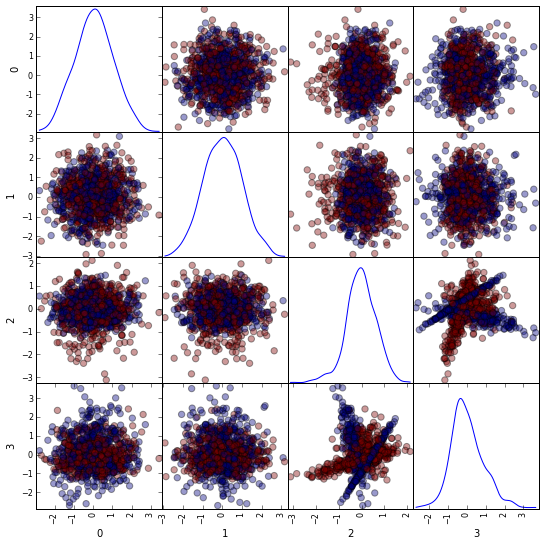

In [2]:
X, y = sklearn.datasets.make_classification(
    n_samples=10000, n_features=4, n_redundant=0, n_informative=2, 
    n_clusters_per_class=2, hypercube=False, random_state=0
)

# Split into train and test
X, Xt, y, yt = sklearn.cross_validation.train_test_split(X, y)

# Visualize sample of the data
ind = np.random.permutation(X.shape[0])[:1000]
df = pd.DataFrame(X[ind])
_ = pd.scatter_matrix(df, figsize=(9, 9), diagonal='kde', marker='o', s=40, alpha=.4, c=y[ind])

Learn and evaluate scikit-learn's logistic regression with stochastic gradient descent (SGD) training. Time and check the classifier's accuracy.

In [3]:
# Train and test the scikit-learn SGD logistic regression.
clf = sklearn.linear_model.SGDClassifier(
    loss='log', n_iter=1000, penalty='l2', alpha=1e-3, class_weight='auto')

%timeit clf.fit(X, y)
yt_pred = clf.predict(Xt)
print('Accuracy: {:.3f}'.format(sklearn.metrics.accuracy_score(yt, yt_pred)))

1 loops, best of 3: 400 ms per loop
Accuracy: 0.545


Save the dataset to HDF5 for loading in Caffe.

In [4]:
# Write out the data to HDF5 files in a temp directory.
# This file is assumed to be caffe_root/examples/hdf5_classification.ipynb
dirname = os.path.abspath('./hdf5_classification/data')
if not os.path.exists(dirname):
    os.makedirs(dirname)

train_filename = os.path.join(dirname, 'train.h5')
test_filename = os.path.join(dirname, 'test.h5')

# HDF5DataLayer source should be a file containing a list of HDF5 filenames.
# To show this off, we'll list the same data file twice.
with h5py.File(train_filename, 'w') as f:
    f['data'] = X
    f['label'] = y.astype(np.float32)
with open(os.path.join(dirname, 'train.txt'), 'w') as f:
    f.write(train_filename + '\n')
    f.write(train_filename + '\n')
    
# HDF5 is pretty efficient, but can be further compressed.
comp_kwargs = {'compression': 'gzip', 'compression_opts': 1}
with h5py.File(test_filename, 'w') as f:
    f.create_dataset('data', data=Xt, **comp_kwargs)
    f.create_dataset('label', data=yt.astype(np.float32), **comp_kwargs)
with open(os.path.join(dirname, 'test.txt'), 'w') as f:
    f.write(test_filename + '\n')

Learn and evaluate logistic regression in Caffe.

In [5]:
def learn_and_test(solver_file):
    caffe.set_mode_cpu()
    solver = caffe.get_solver(solver_file)
    solver.solve()

    accuracy = 0
    test_iters = int(len(Xt) / solver.test_nets[0].blobs['data'].num)
    for i in range(test_iters):
        solver.test_nets[0].forward()
        accuracy += solver.test_nets[0].blobs['accuracy'].data
    accuracy /= test_iters
    return accuracy

%timeit learn_and_test('hdf5_classification/solver.prototxt')
acc = learn_and_test('hdf5_classification/solver.prototxt')
print("Accuracy: {:.3f}".format(acc))

1 loops, best of 3: 379 ms per loop
Accuracy: 0.436


Do the same through the command line interface for detailed output on the model and solving.

In [6]:
!../build/tools/caffe train -solver hdf5_classification/solver.prototxt

I0831 08:26:32.679841  3806 solver.cpp:54] Initializing solver from parameters: 
test_iter: 250
test_interval: 1000
base_lr: 0.01
display: 1000
max_iter: 10000
lr_policy: "step"
gamma: 0.1
momentum: 0.9
weight_decay: 0.0005
stepsize: 5000
snapshot: 10000
snapshot_prefix: "hdf5_classification/data/train"
solver_mode: CPU
net: "hdf5_classification/train_val.prototxt"
I0831 08:26:32.680110  3806 solver.cpp:96] Creating training net from net file: hdf5_classification/train_val.prototxt
I0831 08:26:32.680332  3806 net.cpp:339] The NetState phase (0) differed from the phase (1) specified by a rule in layer data
I0831 08:26:32.680356  3806 net.cpp:339] The NetState phase (0) differed from the phase (1) specified by a rule in layer accuracy
I0831 08:26:32.680408  3806 net.cpp:50] Initializing net from parameters: 
name: "LogisticRegressionNet"
state {
  phase: TRAIN
}
layer {
  name: "data"
  type: "HDF5Data"
  top: "data"
  top: "label"
  include {
    phase: TRAIN
  }
  hdf5_data_param {
   

If you look at output or the `train_val.prototxt`, you'll see that the model is simple logistic regression.
We can make it a little more advanced by introducing a non-linearity between weights that take the input and weights that give the output -- now we have a two-layer network.
That network is given in `train_val2.prototxt`, and that's the only change made in `solver2.prototxt` which we will now use.

The final accuracy of the new network be higher than logistic regression!

In [7]:
def learn_and_test(solver_file):
    caffe.set_mode_cpu()
    solver = caffe.get_solver(solver_file)
    solver.solve()

    accuracy = 0
    test_iters = int(len(Xt) / solver.test_nets[0].blobs['data'].num)
    for i in range(test_iters):
        solver.test_nets[0].forward()
        accuracy += solver.test_nets[0].blobs['accuracy'].data
    accuracy /= test_iters
    return accuracy

%timeit learn_and_test('hdf5_classification/solver2.prototxt')
acc = learn_and_test('hdf5_classification/solver2.prototxt')
print("Accuracy: {:.3f}".format(acc))

1 loops, best of 3: 333 ms per loop
Accuracy: 0.818


Do the same through the command line interface for detailed output on the model and solving.

In [8]:
!../build/tools/caffe train -solver hdf5_classification/solver2.prototxt

I0307 01:34:31.589234 2099749632 caffe.cpp:103] Use CPU.
I0307 01:34:31.872560 2099749632 caffe.cpp:107] Starting Optimization
I0307 01:34:31.872596 2099749632 solver.cpp:32] Initializing solver from parameters: 
test_iter: 250
test_interval: 1000
base_lr: 0.01
display: 1000
max_iter: 10000
lr_policy: "step"
gamma: 0.1
momentum: 0.9
weight_decay: 0.0005
stepsize: 5000
snapshot: 10000
snapshot_prefix: "hdf5_classification/data/train"
solver_mode: CPU
net: "hdf5_classification/train_val2.prototxt"
I0307 01:34:31.872687 2099749632 solver.cpp:70] Creating training net from net file: hdf5_classification/train_val2.prototxt
I0307 01:34:31.872865 2099749632 net.cpp:257] The NetState phase (0) differed from the phase (1) specified by a rule in layer data
I0307 01:34:31.872882 2099749632 net.cpp:257] The NetState phase (0) differed from the phase (1) specified by a rule in layer accuracy
I0307 01:34:31.872891 2099749632 net.cpp:42] Initializing net from parameters: 
name: "LogisticRegressionNet

In [9]:
# Clean up (comment this out if you want to examine the hdf5_classification/data directory).
shutil.rmtree(dirname)